In [ ]:
# !pip install shap
# !pip install --upgrade numpy
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import plotly.express as px
# import plotly.graph_objects as go
import seaborn as sns
# import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

# from pyod.models.ecod import ECOD
# from yellowbrick.cluster import KElbowVisualizer

# import lightgbm as lgb
# import prince

In [22]:
data_train=pd.read_csv('train.csv', sep = ";")
data_test=pd.read_csv('test.csv', sep = ";")

In [23]:
data_train.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# take data 

In [24]:
df=data_train[['age','job','marital','education','default','balance','housing','loan']]

In [25]:
df.describe()

,age,balance
count,45211.000000,45211.000000
mean,40.936210,1362.272058
std,10.618762,3044.765829
min,18.000000,-8019.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,95.000000,102127.000000


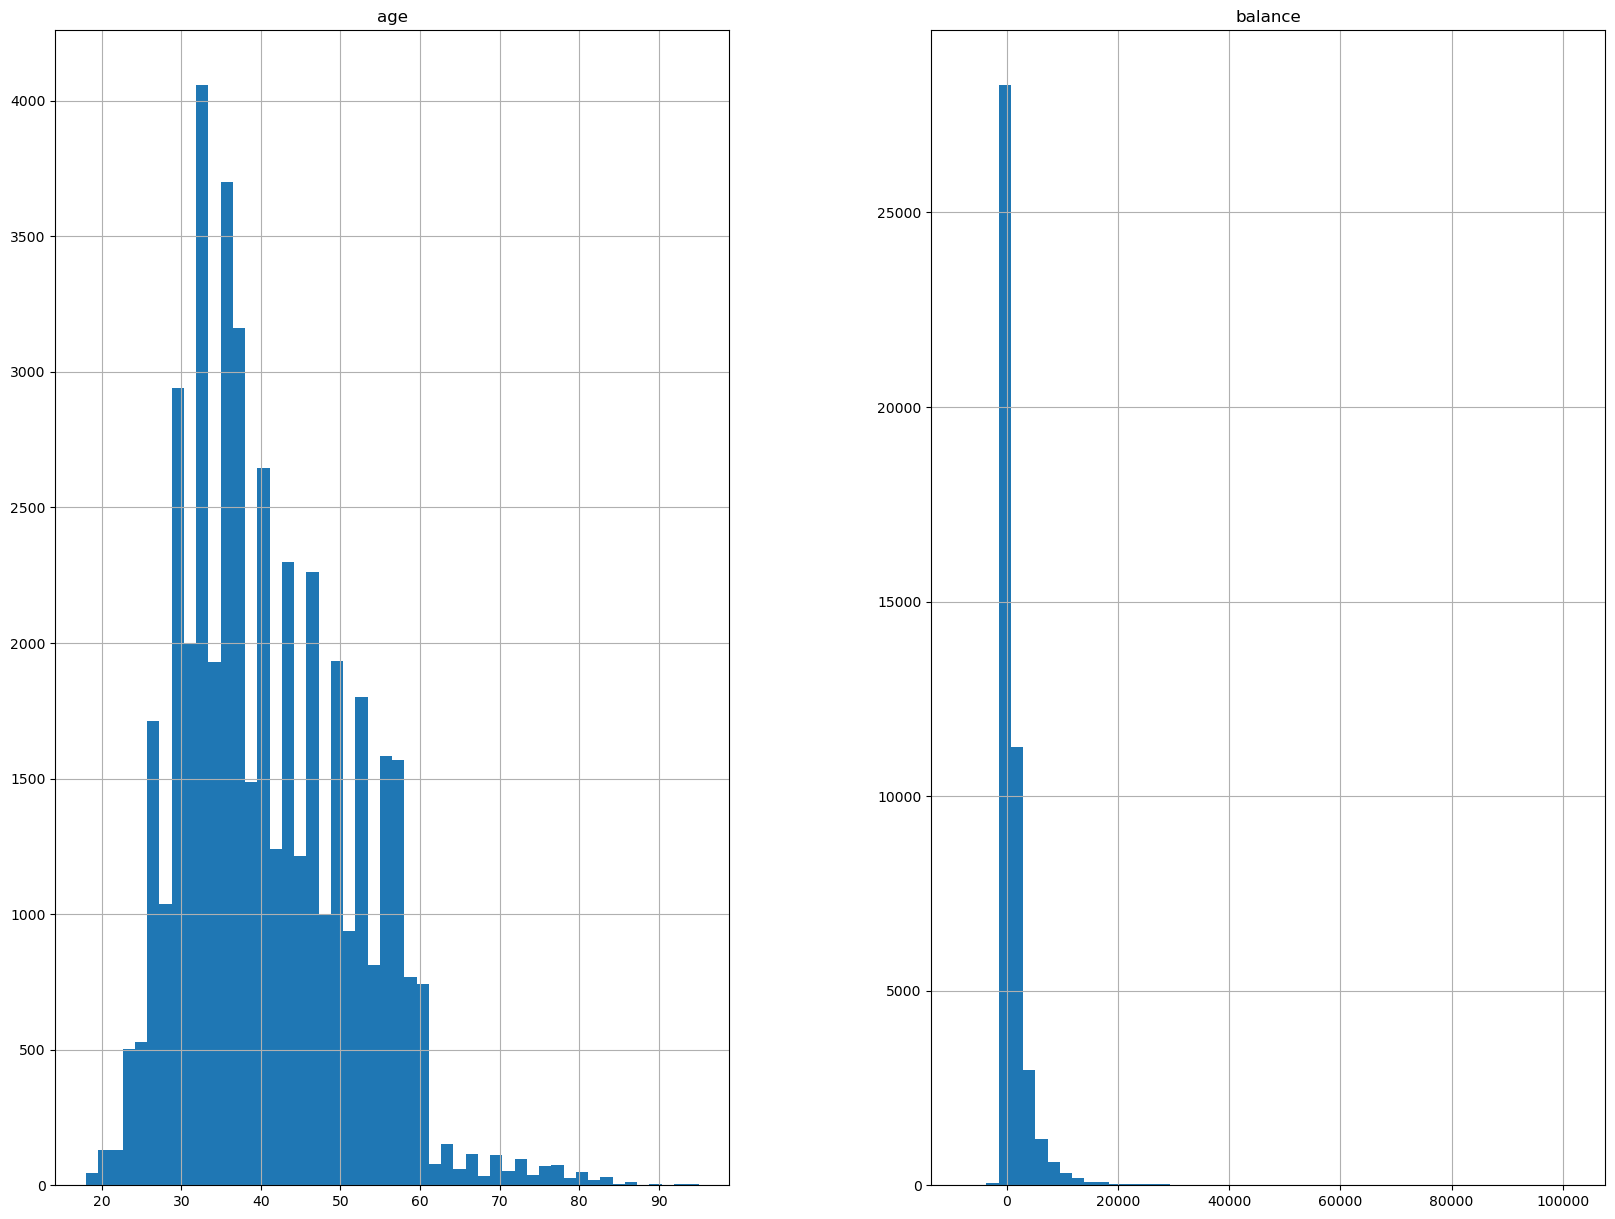

In [26]:
from matplotlib import pyplot as plt

df.hist(bins=50, figsize=(20, 15));

we see balance column have a lot of outliers

# Encode Categorical Data
# Encode Independent variable (X)

In [27]:
#df=df.values
df

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,yes,no
4,33,unknown,single,unknown,no,1,no,no
...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no
45207,71,retired,divorced,primary,no,1729,no,no
45208,72,retired,married,secondary,no,5715,no,no
45209,57,blue-collar,married,secondary,no,668,no,no


In [28]:
import numpy as np
import warnings
np.warnings = warnings


In [29]:

from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Xác định các đặc trưng cần được xử lý
categorical_features_onehot = ["default", "housing", "loan", "job", "marital"]
categorical_features_ordinal = ["education"]
numerical_features = ["age", "balance"]

#Create preprocessing steps for each feature type
categorical_transformer_onehot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
    ])

categorical_transformer_ordinal = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ])

numerical_transformer = Pipeline(
    steps=[
        ("encoder", PowerTransformer())
    ])

# Create a ColumnTransformer to apply preprocessing steps to each feature type
preprocessor = ColumnTransformer(transformers=[
    ('cat_onehot', categorical_transformer_onehot, categorical_features_onehot),
    ('cat_ordinal', categorical_transformer_ordinal, categorical_features_ordinal),
    ('num', numerical_transformer, numerical_features)
])

# Create pipeline 
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
)
# Fit pipeline
pipe_fit = pipeline.fit(df)

# Get the characteristic name of OneHotEncoder
onehot_feature_names = pipe_fit.named_steps['preprocessor'].named_transformers_['cat_onehot'].named_steps['encoder'].get_feature_names_out(categorical_features_onehot)

# Get the characteristic name of PowerTransformer
numerical_feature_names = pipe_fit.named_steps['preprocessor'].named_transformers_['num'].named_steps['encoder'].get_feature_names_out(numerical_features)

# Aggregate all feature names, including direct classification features
all_feature_names = np.concatenate([onehot_feature_names, numerical_feature_names, categorical_features_ordinal])

# Converts the data to a DataFrame with the specified characteristic name
data = pd.DataFrame(pipe_fit.transform(df), columns=all_feature_names)


In [30]:
data.columns.tolist()

['default_yes',
 'housing_yes',
 'loan_yes',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'age',
 'balance',
 'education']

In [31]:
data

,default_yes,housing_yes,loan_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,age,balance,education
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.473637,0.414773
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.429379,-0.410774
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.709873,-0.431122
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.683128,0.197685
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,-0.709873,-0.432119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.993503,-0.052398
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.207438,0.275122
45208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.257237,1.495765
45209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.409327,-0.114235


 # Encode Dependent Variable

In [32]:
# !pip install pyod
from pyod.models.ecod import ECOD
clf = ECOD()
clf.fit(data)
outliers = clf.predict(data) 

data["outliers"] = outliers
df["outliers"] = outliers

# Data without outliers
data_no_outliers = data[data["outliers"] == 0]
data_no_outliers = data_no_outliers.drop(["outliers"], axis = 1)

# Data with Outliers
data_with_outliers = data.copy()
data_with_outliers = data_with_outliers.drop(["outliers"], axis = 1)

# Original Data with Outliers
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

/var/folders/p7/t8mf_9w1121ch7f5wkpf02_r0000gn/T/ipykernel_84394/1815141309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers"] = outliers


In [33]:
print(data_no_outliers.shape)
print(data_with_outliers.shape)
print(df_no_outliers.shape)

(40690, 19)
(45211, 19)
(40690, 8)


In [34]:
data_with_outliers

,default_yes,housing_yes,loan_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,age,balance,education
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.473637,0.414773
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.429379,-0.410774
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.709873,-0.431122
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.683128,0.197685
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,-0.709873,-0.432119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.993503,-0.052398
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.207438,0.275122
45208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.257237,1.495765
45209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.409327,-0.114235


In [35]:
data_no_outliers

,default_yes,housing_yes,loan_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,age,balance,education
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.473637,0.414773
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.429379,-0.410774
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.709873,-0.431122
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.683128,0.197685
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.472563,-0.302591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.589198,-0.159379
45205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.859071,-0.181020
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.993503,-0.052398
45209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.409327,-0.114235


# Modelling

/Users/nguyentoan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


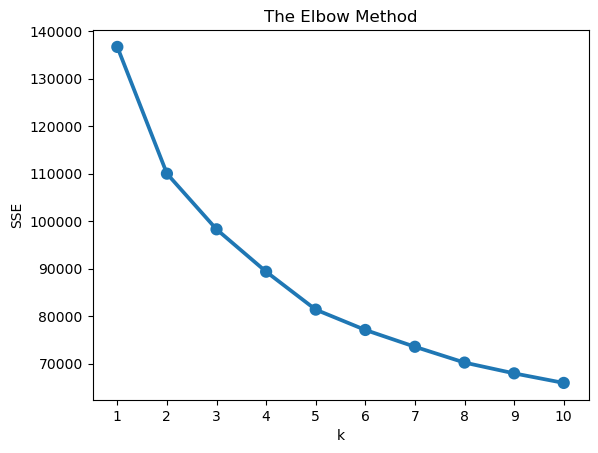

In [36]:
# cluster 
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_no_outliers)
    sse[k] = kmeans.inertia_ 
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [37]:
km = KMeans(n_clusters= 5 , 
            init= 'k-means++' , 
            n_init= 10 , 
            max_iter= 100 , 
            random_state= 42 ) 

clusters_predict = km.fit_predict(data_no_outliers) 


# Evaluation

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters_predict)}")
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers,clusters_predict)}")
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters_predict)}")

Davies bouldin score: 1.6775659296391372
Calinski Score: 6914.724747148267
Silhouette Score: 0.16728699409070363


In [39]:
data_no_outlie

,default_yes,housing_yes,loan_yes,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,age,balance,education
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.473637,0.414773
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.429379,-0.410774
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.709873,-0.431122
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.683128,0.197685
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.472563,-0.302591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.589198,-0.159379
45205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.859071,-0.181020
45206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.993503,-0.052398
45209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.409327,-0.114235


In [46]:
df_no_outliers = df[df.outliers == 0]
df_no_outliers["cluster"] = clusters_predict
df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
        
    }
).reset_index()

/var/folders/p7/t8mf_9w1121ch7f5wkpf02_r0000gn/T/ipykernel_84394/3159598569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers["cluster"] = clusters_predict


,cluster,job,marital,education,housing,loan,age,balance,default
0,0,management,married,tertiary,no,no,43.773960,872.797951,no
1,1,blue-collar,married,secondary,no,no,50.220989,836.407504,no
2,2,blue-collar,married,secondary,yes,no,34.569409,592.025644,no
3,3,management,married,secondary,yes,no,42.183012,7526.310217,no
4,4,technician,single,secondary,yes,no,32.069740,794.696306,no
